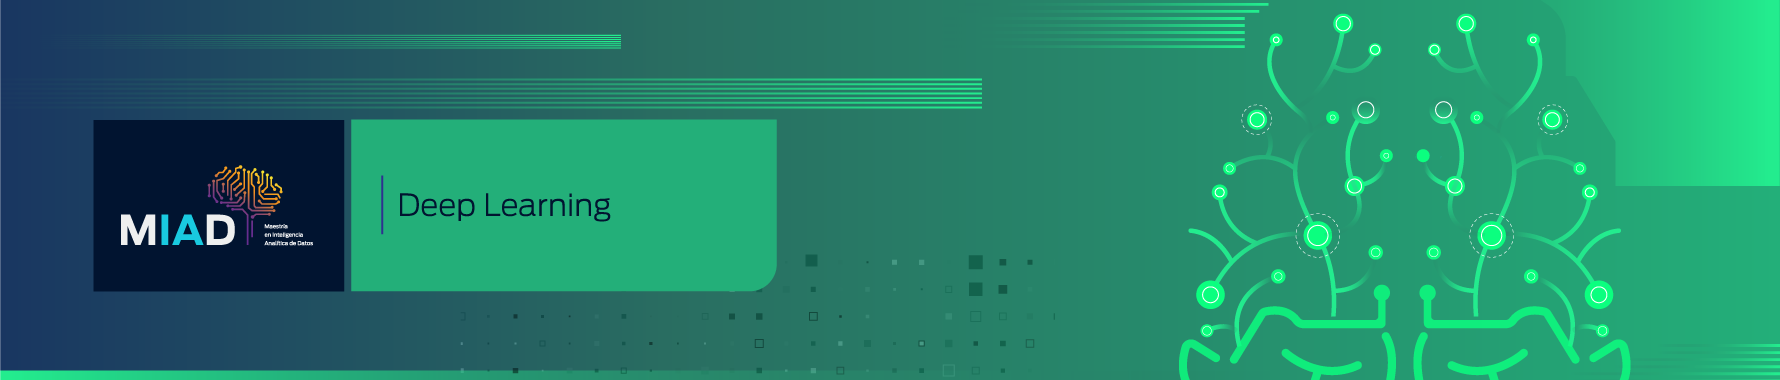



## Estimación de red neuronal con múltiples capas (Multilayer Perceptor)

### Propósito 

En este *notebook*, deberán aplicar sus conocimientos sobre la construcción y calibración de una red neuronal de tipo _feedforward_. Para ello, deberán entregar un _notebook_ en el cual se desarrolle una red neuronal de dos capas ocultas y cuya calibración se realice con el método de gradiente descendiente.

### Instrucciones generales

1. Descarguen este *notebook* y agréguenlo al repositorio de su preferencia  para que lo puedan trabajar grupalmente.

2. Para que la actividad sea calificada, deberán subir únicamente este mismo archivo con la extensión ".ipynb" a la actividad de "entrega calificada por el personal" correspondiente a este caso. Nota: el archivo que suban debe poder ejecutarse localmente cuando sea descargado por el tutor, asumiendo que la base de datos de la actividad ya ha sido importada en el correspondiente archivo separado por comas (.csv).

### Librerías a importar

A continuación se muestran los comandos a ejecutar para poder implementar los procedimientos de este notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Pasos para implementar manualmente el algoritmo de descenso de gradiente

1. Cargar los datos 
2. Separar la muestra 
3. Definir funciones de la red neuronal
4. Realizar el ensamblaje de la función de red neuronal
5. Predecir utilizando la red neuronal 
6. Evaluar la predicción

### 1. Cargar los datos

Para realizar la actividad, cargue los datos a usar en este *notebook*  que fueron extraídos de imágenes que fueron tomadas de billetes. Para su digitalización, se utilizó una cámara industrial usada para la impresión. Luego, las imágenes de 400x400 pixeles se sometieron a un procedimiento de transformación de onda (Wavelet transformation) con la intención de extraer los features para la predicción.

En este contexto, la variable de respuesta corresponde a si un billete es auténtico (y=1) o si no lo es (y=0) y las variables predictivas son las siguientes:


1. *variance* *of* *Wavelet* *Transformed* *image* *(continuous)*
2. *skewness* *of* *Wavelet* *Transformed* *image* *(continuous)*
3. *curtosis* *of* *Wavelet* *Transformed* *image* *(continuous)*
4. *entropy* *of* *image* *(continuous)*

In [2]:
data = np.genfromtxt('data_banknote_authentication.txt', delimiter = ',')
X = data[:,:4]
y = data[:, 4]

### 2. Separar la muestra
Luego hacemos la separación de los datos en entrenamiento y evaluación. Además, podemos observar las dimensiones de estos datos como se muestra a continuación:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
print ('X Train dimensiones: ', X_train.shape)
print ('Y Train dimensiones: ', y_train.shape)
print ('X Test dimensiones: ', X_test.shape)
print ('Y Test dimensiones: ', y_test.shape)

X Train dimensiones:  (1097, 4)
Y Train dimensiones:  (1097, 1)
X Test dimensiones:  (275, 4)
Y Test dimensiones:  (275, 1)


### Actividad de programación

Para esta actividad deberán construir una red neuronal con un diseño particular y un procedimiento de gradiente descendiente para la estimación de los parámetros de dicha red, sin el uso de librerías adicionales a las que se cargaron inicialmente en este notebook. A continuación se muestra la estructura de la red neuronal que se solicita:

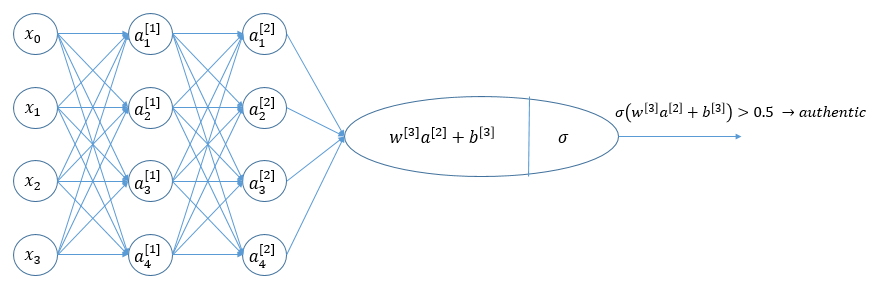

Figura 1. Diagrama de red neuronal de dos capas ocultas. 

Como se puede observar, se está solicitando una red neuronal de clasificación con dos capas ocultas, cada una de ellas con cuatro nodos.
Para lograr lo anterior, en esta actividad se espera que utilice como base el notebook "Redes neuronales: calibración de una red neuronal de una capa".

### 3.  Definir funciones de la red neuronal


Ahora, haremos una función que determine las dimensiones de los vectores que se utilizarán como input y output:

In [4]:
def estructuras(X, Y):
    input_unit = X.shape[1] # Dimensión de entrada
    hidden_unit_1 = 4 # Unidades de capa oculta 1
    hidden_unit_2 = 4 # Unidades de capa oculta 2
    output_unit = Y.shape[1] # Dimensión de variable de salida
    return (input_unit, hidden_unit_1, hidden_unit_2, output_unit)
(input_unit, hidden_unit_1, hidden_unit_2, output_unit) = estructuras(X_train, y_train)
print("Dimensión de capa entrada = " + str(input_unit))
print("Dimensión de capa oculta 1 = " + str(hidden_unit_1))
print("Dimensión de capa oculta 2 = " + str(hidden_unit_2))
print("Dimensión de capa de salida = " + str(output_unit))

Dimensión de capa entrada = 4
Dimensión de capa oculta 1 = 4
Dimensión de capa oculta 2 = 4
Dimensión de capa de salida = 1


Después haremos una función que, dada la dimensión de entrada de las capas ocultas y de salida, genere un valor aleatorio para la inicialización de los parámetros correspondientes:

In [5]:
def inicializacion(input_unit, hidden_unit_1, hidden_unit_2, output_unit):
    #Se fija una semilla (seed) igual a 2 para este ejercicio para poder reproducir los mismos resultados.
    np.random.seed(2) 
    W1 = np.random.randn(input_unit, hidden_unit_1)*0.01
    b1 = np.zeros((1, hidden_unit_1))
    W2 = np.random.randn(hidden_unit_1, hidden_unit_2)*0.01
    b2 = np.zeros((1, hidden_unit_2))
    W3 = np.random.randn(hidden_unit_2, output_unit)*0.01
    b3 = np.zeros((1, output_unit))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    return parameters

También generamos una función para la activación de tipo sigmoide dada por:
    
$$f(x)=\frac{1}{1+e^{-x}}=\frac{e^{x}}{1+e^{x}}$$

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

Ahora, establecemos una función que permita realizar la propagación hacia adelante de la información en una red neuronal. Es decir, actualizar el valor de todas las variables en la red en función de los valores correspondientes de los parámetros $W$ y $b$ en la iteración actual. Lo anterior se encuentra definido por la evaluación de la función sigmoide sobre el producto punto de los pesos por los valores de las neuronas más un intercepto:

In [7]:
def forward_propagation(X, parameters):
    
    #Se cargan los valores de los parámetros
    
    W1 = parameters['W1'] #Valor de los pesos de la primera capa
    b1 = parameters['b1'] #Valor de los interceptos de la primera capa
    W2 = parameters['W2'] #Valor de los pesos de la segunda capa
    b2 = parameters['b2'] #Valor de los interceptos de la segunda capa
    W3 = parameters['W3'] #Valor de los pesos de la salida
    b3 = parameters['b3'] #Valor de los interceptos de la salida
    
    Z1 = np.dot(X, W1) + b1 #Cálculo de la transformación afín de la primera capa
    A1 = sigmoid(Z1) #Evaluación de la función sigmoide de la primera capa
    Z2 = np.dot(A1, W2) + b2 #Cálculo de la transformación afín de la segunda capa
    A2 = sigmoid(Z2) #Evaluación de la función sigmoide de la segunda capa
    Z3 = np.dot(A2, W3) + b3 #Cálculo de la transformación afín de la salida
    A3 = sigmoid(Z3) #Evaluación de la función sigmoide de la salida
    cache = {"Z1": Z1,"A1": A1,"Z2": Z2,"A2": A2, "Z3": Z3,"A3": A3}
    
    return A3, cache

Luego, procedemos a definir la función de pérdida para los problemas de clasificación binarios. En este caso particular, se utilizará la función de entropia cruzada para una variable aleatoria con distribución Bernoulli, que corresponde a la función objetivo que se busca minimizar:

$$L(W,B)=-{1\over n}\sum_{i=1}^{n}y_{i}log(A^{[3]}_i)+(1-y_{i})log((1-A^{[3]}_i))$$

In [8]:
def cross_entropy_cost(A3, Y, parameters):
    # Muestras de entrenamiento
    n = Y.shape[0] 
    
    # Calcular cross entropy
    logprobs = np.multiply(np.log(A3), Y) + np.multiply((1-Y), np.log(1 - A3))
    cost = - np.sum(logprobs) / n
    cost = float(np.squeeze(cost))    
    
    return cost

Posteriormente, implementamos una función que calcule el gradiente de la función de pérdida con respecto a los parámetros de calibración de la red neuronal (pesos e interceptos). Para ello, recurrimos al procedimiento de backpropagation, el cual es una manera de calcular, numéricamente, este gradiente aprovechándose de la regla de la cadena, la cual resulta útil debido a que una red neuronal se puede interpretar como la composición de las funciones de activación de cada una de sus capas.

In [9]:
def backward_propagation(parameters, cache, X, Y):
    
    #Muestras de entrenamiento
    
    n = X.shape[0]
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    A1 = cache['A1']
    A2 = cache['A2']
    A3 = cache['A3']
    
    dZ3 = (1/n) *(A3-Y)
    dW3 = np.dot(A2.T,dZ3)
    db3 = np.sum(dZ3, axis=0, keepdims=True)
    
    dZ2 = (1/n) *(A2-Y)
    dW2 = np.dot(A1.T,dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    
    dZ1 = np.multiply(np.dot(dZ2,W2.T), A1 - np.power(A1, 2))
    dW1 = np.dot(X.T,dZ1) 
    db1 = np.sum(dZ1, axis=0, keepdims=True)
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2,"db2": db2, "dW3": dW3,"db3": db3}
    return grads

Una vez se tiene la función para calcular el gradiente de la función de costo utilizando el método de backpropagation, se procede a utilizar este gradiente para actualizar los valores de los parámetros de acuerdo a una tasa de aprendizaje:

$$W(t+1)=W(t)-\alpha {\nabla}L(W(t))$$

In [10]:
def gradient_descent(parameters, grads, learning_rate = 0.01):
    
    #Se capturan los valores actuales para los parámetros de la red neuronal
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    #Se capturan los valores del gradiente para cada una de sus componentes
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    dW3 = grads['dW3']
    db3 = grads['db3']
    
    
    #Se actualizan los valores de los parámetros siguiendo la dirección contraria del gradiente
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    
    parameters = {"W1": W1, "b1": b1,"W2": W2,"b2": b2,"W3": W3,"b3": b3}
    
    return parameters

### 4. Realizar el ensamblaje de la función de red neuronal

Se utilizan todos los procedimientos definidos anteriormente para calibrar los parámetros de una red neuronal:

In [11]:
X=X_train
Y=y_train
hidden_unit_1=4
hidden_unit_2=4
num_iterations=15000
input_unit = estructuras(X, Y)[0]
output_unit = estructuras(X, Y)[3]

#Se inicializan los parámetros de manera aleatoria
parameters = inicializacion(input_unit, hidden_unit_1,hidden_unit_2, output_unit)
   
W1 = parameters['W1']
b1 = parameters['b1']
W2 = parameters['W2']
b2 = parameters['b2']
W3 = parameters['W3']
b3 = parameters['b3']
costs=[]

In [12]:
def neural_network_model(X, Y, hidden_unit_1, hidden_unit_2, num_iterations = 10000):
    np.random.seed(3)
    
    
    input_unit = estructuras(X, Y)[0]
    output_unit = estructuras(X, Y)[3]
    
    #Se inicializan los parámetros de manera aleatoria
    parameters = inicializacion(input_unit, hidden_unit_1, hidden_unit_2, output_unit)
   
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    costs=[]
    
    
    for i in range(0, num_iterations):
                
        A3, cache = forward_propagation(X, parameters) #Se calcula la salida de la red para los datos utilizados y los valores de los parámetros para cada iteración
        
        cost = cross_entropy_cost(A3, Y, parameters) #Se calcula la función de costos
        
        costs.append(cost) #Se guardan el valor de la función de costos para cada iteración
        
        grads = backward_propagation(parameters, cache, X, Y) #Se calcula el gradiente de la función de costos utilizando el método de backpropagation para cada iteración
        
        parameters = gradient_descent(parameters, grads) #Se actualiza el valor de los parámetros de acuerdo al gradiente calculado en cada iteración
        if i % 5 == 0:
            print ("Costo en la iteracion  %i: %f" %(i, cost))
    return parameters, costs

parameters, costs = neural_network_model(X_train, y_train, 4, 4, num_iterations=15000)


Costo en la iteracion  0: 0.692976
Costo en la iteracion  5: 0.692637
Costo en la iteracion  10: 0.692316
Costo en la iteracion  15: 0.692012
Costo en la iteracion  20: 0.691723
Costo en la iteracion  25: 0.691450
Costo en la iteracion  30: 0.691190
Costo en la iteracion  35: 0.690944
Costo en la iteracion  40: 0.690711
Costo en la iteracion  45: 0.690490
Costo en la iteracion  50: 0.690280
Costo en la iteracion  55: 0.690080
Costo en la iteracion  60: 0.689891
Costo en la iteracion  65: 0.689712
Costo en la iteracion  70: 0.689542
Costo en la iteracion  75: 0.689382
Costo en la iteracion  80: 0.689229
Costo en la iteracion  85: 0.689085
Costo en la iteracion  90: 0.688948
Costo en la iteracion  95: 0.688819
Costo en la iteracion  100: 0.688697
Costo en la iteracion  105: 0.688582
Costo en la iteracion  110: 0.688473
Costo en la iteracion  115: 0.688371
Costo en la iteracion  120: 0.688275
Costo en la iteracion  125: 0.688185
Costo en la iteracion  130: 0.688100
Costo en la iteracion  

Costo en la iteracion  1120: 0.618421
Costo en la iteracion  1125: 0.617212
Costo en la iteracion  1130: 0.615994
Costo en la iteracion  1135: 0.614768
Costo en la iteracion  1140: 0.613535
Costo en la iteracion  1145: 0.612293
Costo en la iteracion  1150: 0.611045
Costo en la iteracion  1155: 0.609789
Costo en la iteracion  1160: 0.608525
Costo en la iteracion  1165: 0.607254
Costo en la iteracion  1170: 0.605976
Costo en la iteracion  1175: 0.604691
Costo en la iteracion  1180: 0.603399
Costo en la iteracion  1185: 0.602101
Costo en la iteracion  1190: 0.600795
Costo en la iteracion  1195: 0.599484
Costo en la iteracion  1200: 0.598165
Costo en la iteracion  1205: 0.596841
Costo en la iteracion  1210: 0.595510
Costo en la iteracion  1215: 0.594173
Costo en la iteracion  1220: 0.592830
Costo en la iteracion  1225: 0.591481
Costo en la iteracion  1230: 0.590126
Costo en la iteracion  1235: 0.588766
Costo en la iteracion  1240: 0.587400
Costo en la iteracion  1245: 0.586029
Costo en la 

Costo en la iteracion  2285: 0.306878
Costo en la iteracion  2290: 0.305875
Costo en la iteracion  2295: 0.304876
Costo en la iteracion  2300: 0.303881
Costo en la iteracion  2305: 0.302891
Costo en la iteracion  2310: 0.301904
Costo en la iteracion  2315: 0.300921
Costo en la iteracion  2320: 0.299942
Costo en la iteracion  2325: 0.298968
Costo en la iteracion  2330: 0.297997
Costo en la iteracion  2335: 0.297030
Costo en la iteracion  2340: 0.296067
Costo en la iteracion  2345: 0.295108
Costo en la iteracion  2350: 0.294153
Costo en la iteracion  2355: 0.293201
Costo en la iteracion  2360: 0.292254
Costo en la iteracion  2365: 0.291310
Costo en la iteracion  2370: 0.290371
Costo en la iteracion  2375: 0.289435
Costo en la iteracion  2380: 0.288503
Costo en la iteracion  2385: 0.287575
Costo en la iteracion  2390: 0.286651
Costo en la iteracion  2395: 0.285731
Costo en la iteracion  2400: 0.284814
Costo en la iteracion  2405: 0.283902
Costo en la iteracion  2410: 0.282993
Costo en la 

Costo en la iteracion  3420: 0.160501
Costo en la iteracion  3425: 0.160120
Costo en la iteracion  3430: 0.159740
Costo en la iteracion  3435: 0.159362
Costo en la iteracion  3440: 0.158985
Costo en la iteracion  3445: 0.158610
Costo en la iteracion  3450: 0.158237
Costo en la iteracion  3455: 0.157865
Costo en la iteracion  3460: 0.157494
Costo en la iteracion  3465: 0.157125
Costo en la iteracion  3470: 0.156758
Costo en la iteracion  3475: 0.156392
Costo en la iteracion  3480: 0.156027
Costo en la iteracion  3485: 0.155664
Costo en la iteracion  3490: 0.155303
Costo en la iteracion  3495: 0.154943
Costo en la iteracion  3500: 0.154584
Costo en la iteracion  3505: 0.154227
Costo en la iteracion  3510: 0.153871
Costo en la iteracion  3515: 0.153517
Costo en la iteracion  3520: 0.153164
Costo en la iteracion  3525: 0.152813
Costo en la iteracion  3530: 0.152463
Costo en la iteracion  3535: 0.152115
Costo en la iteracion  3540: 0.151768
Costo en la iteracion  3545: 0.151422
Costo en la 

Costo en la iteracion  4580: 0.102064
Costo en la iteracion  4585: 0.101903
Costo en la iteracion  4590: 0.101743
Costo en la iteracion  4595: 0.101583
Costo en la iteracion  4600: 0.101424
Costo en la iteracion  4605: 0.101265
Costo en la iteracion  4610: 0.101107
Costo en la iteracion  4615: 0.100949
Costo en la iteracion  4620: 0.100792
Costo en la iteracion  4625: 0.100636
Costo en la iteracion  4630: 0.100480
Costo en la iteracion  4635: 0.100324
Costo en la iteracion  4640: 0.100169
Costo en la iteracion  4645: 0.100014
Costo en la iteracion  4650: 0.099860
Costo en la iteracion  4655: 0.099707
Costo en la iteracion  4660: 0.099554
Costo en la iteracion  4665: 0.099401
Costo en la iteracion  4670: 0.099249
Costo en la iteracion  4675: 0.099097
Costo en la iteracion  4680: 0.098946
Costo en la iteracion  4685: 0.098796
Costo en la iteracion  4690: 0.098646
Costo en la iteracion  4695: 0.098496
Costo en la iteracion  4700: 0.098347
Costo en la iteracion  4705: 0.098198
Costo en la 

Costo en la iteracion  5735: 0.075427
Costo en la iteracion  5740: 0.075345
Costo en la iteracion  5745: 0.075264
Costo en la iteracion  5750: 0.075183
Costo en la iteracion  5755: 0.075102
Costo en la iteracion  5760: 0.075021
Costo en la iteracion  5765: 0.074941
Costo en la iteracion  5770: 0.074861
Costo en la iteracion  5775: 0.074781
Costo en la iteracion  5780: 0.074701
Costo en la iteracion  5785: 0.074621
Costo en la iteracion  5790: 0.074542
Costo en la iteracion  5795: 0.074462
Costo en la iteracion  5800: 0.074383
Costo en la iteracion  5805: 0.074304
Costo en la iteracion  5810: 0.074226
Costo en la iteracion  5815: 0.074147
Costo en la iteracion  5820: 0.074069
Costo en la iteracion  5825: 0.073991
Costo en la iteracion  5830: 0.073913
Costo en la iteracion  5835: 0.073836
Costo en la iteracion  5840: 0.073758
Costo en la iteracion  5845: 0.073681
Costo en la iteracion  5850: 0.073604
Costo en la iteracion  5855: 0.073527
Costo en la iteracion  5860: 0.073450
Costo en la 

Costo en la iteracion  6940: 0.060513
Costo en la iteracion  6945: 0.060466
Costo en la iteracion  6950: 0.060419
Costo en la iteracion  6955: 0.060373
Costo en la iteracion  6960: 0.060326
Costo en la iteracion  6965: 0.060280
Costo en la iteracion  6970: 0.060234
Costo en la iteracion  6975: 0.060188
Costo en la iteracion  6980: 0.060142
Costo en la iteracion  6985: 0.060096
Costo en la iteracion  6990: 0.060050
Costo en la iteracion  6995: 0.060004
Costo en la iteracion  7000: 0.059959
Costo en la iteracion  7005: 0.059913
Costo en la iteracion  7010: 0.059868
Costo en la iteracion  7015: 0.059822
Costo en la iteracion  7020: 0.059777
Costo en la iteracion  7025: 0.059732
Costo en la iteracion  7030: 0.059687
Costo en la iteracion  7035: 0.059642
Costo en la iteracion  7040: 0.059597
Costo en la iteracion  7045: 0.059552
Costo en la iteracion  7050: 0.059508
Costo en la iteracion  7055: 0.059463
Costo en la iteracion  7060: 0.059418
Costo en la iteracion  7065: 0.059374
Costo en la 

Costo en la iteracion  8195: 0.051209
Costo en la iteracion  8200: 0.051180
Costo en la iteracion  8205: 0.051150
Costo en la iteracion  8210: 0.051121
Costo en la iteracion  8215: 0.051092
Costo en la iteracion  8220: 0.051063
Costo en la iteracion  8225: 0.051034
Costo en la iteracion  8230: 0.051005
Costo en la iteracion  8235: 0.050976
Costo en la iteracion  8240: 0.050947
Costo en la iteracion  8245: 0.050918
Costo en la iteracion  8250: 0.050889
Costo en la iteracion  8255: 0.050860
Costo en la iteracion  8260: 0.050831
Costo en la iteracion  8265: 0.050803
Costo en la iteracion  8270: 0.050774
Costo en la iteracion  8275: 0.050745
Costo en la iteracion  8280: 0.050717
Costo en la iteracion  8285: 0.050688
Costo en la iteracion  8290: 0.050660
Costo en la iteracion  8295: 0.050631
Costo en la iteracion  8300: 0.050603
Costo en la iteracion  8305: 0.050575
Costo en la iteracion  8310: 0.050546
Costo en la iteracion  8315: 0.050518
Costo en la iteracion  8320: 0.050490
Costo en la 

Costo en la iteracion  9380: 0.045400
Costo en la iteracion  9385: 0.045380
Costo en la iteracion  9390: 0.045359
Costo en la iteracion  9395: 0.045339
Costo en la iteracion  9400: 0.045318
Costo en la iteracion  9405: 0.045298
Costo en la iteracion  9410: 0.045278
Costo en la iteracion  9415: 0.045258
Costo en la iteracion  9420: 0.045237
Costo en la iteracion  9425: 0.045217
Costo en la iteracion  9430: 0.045197
Costo en la iteracion  9435: 0.045177
Costo en la iteracion  9440: 0.045157
Costo en la iteracion  9445: 0.045137
Costo en la iteracion  9450: 0.045117
Costo en la iteracion  9455: 0.045097
Costo en la iteracion  9460: 0.045077
Costo en la iteracion  9465: 0.045057
Costo en la iteracion  9470: 0.045037
Costo en la iteracion  9475: 0.045017
Costo en la iteracion  9480: 0.044997
Costo en la iteracion  9485: 0.044977
Costo en la iteracion  9490: 0.044957
Costo en la iteracion  9495: 0.044937
Costo en la iteracion  9500: 0.044918
Costo en la iteracion  9505: 0.044898
Costo en la 

Costo en la iteracion  10740: 0.040737
Costo en la iteracion  10745: 0.040722
Costo en la iteracion  10750: 0.040708
Costo en la iteracion  10755: 0.040693
Costo en la iteracion  10760: 0.040679
Costo en la iteracion  10765: 0.040665
Costo en la iteracion  10770: 0.040651
Costo en la iteracion  10775: 0.040636
Costo en la iteracion  10780: 0.040622
Costo en la iteracion  10785: 0.040608
Costo en la iteracion  10790: 0.040594
Costo en la iteracion  10795: 0.040580
Costo en la iteracion  10800: 0.040565
Costo en la iteracion  10805: 0.040551
Costo en la iteracion  10810: 0.040537
Costo en la iteracion  10815: 0.040523
Costo en la iteracion  10820: 0.040509
Costo en la iteracion  10825: 0.040495
Costo en la iteracion  10830: 0.040481
Costo en la iteracion  10835: 0.040467
Costo en la iteracion  10840: 0.040453
Costo en la iteracion  10845: 0.040439
Costo en la iteracion  10850: 0.040425
Costo en la iteracion  10855: 0.040411
Costo en la iteracion  10860: 0.040397
Costo en la iteracion  10

Costo en la iteracion  11990: 0.037617
Costo en la iteracion  11995: 0.037607
Costo en la iteracion  12000: 0.037596
Costo en la iteracion  12005: 0.037585
Costo en la iteracion  12010: 0.037574
Costo en la iteracion  12015: 0.037563
Costo en la iteracion  12020: 0.037553
Costo en la iteracion  12025: 0.037542
Costo en la iteracion  12030: 0.037531
Costo en la iteracion  12035: 0.037521
Costo en la iteracion  12040: 0.037510
Costo en la iteracion  12045: 0.037499
Costo en la iteracion  12050: 0.037488
Costo en la iteracion  12055: 0.037478
Costo en la iteracion  12060: 0.037467
Costo en la iteracion  12065: 0.037456
Costo en la iteracion  12070: 0.037446
Costo en la iteracion  12075: 0.037435
Costo en la iteracion  12080: 0.037424
Costo en la iteracion  12085: 0.037414
Costo en la iteracion  12090: 0.037403
Costo en la iteracion  12095: 0.037393
Costo en la iteracion  12100: 0.037382
Costo en la iteracion  12105: 0.037372
Costo en la iteracion  12110: 0.037361
Costo en la iteracion  12

Costo en la iteracion  13210: 0.035284
Costo en la iteracion  13215: 0.035275
Costo en la iteracion  13220: 0.035267
Costo en la iteracion  13225: 0.035258
Costo en la iteracion  13230: 0.035250
Costo en la iteracion  13235: 0.035241
Costo en la iteracion  13240: 0.035233
Costo en la iteracion  13245: 0.035225
Costo en la iteracion  13250: 0.035216
Costo en la iteracion  13255: 0.035208
Costo en la iteracion  13260: 0.035199
Costo en la iteracion  13265: 0.035191
Costo en la iteracion  13270: 0.035183
Costo en la iteracion  13275: 0.035174
Costo en la iteracion  13280: 0.035166
Costo en la iteracion  13285: 0.035158
Costo en la iteracion  13290: 0.035149
Costo en la iteracion  13295: 0.035141
Costo en la iteracion  13300: 0.035133
Costo en la iteracion  13305: 0.035125
Costo en la iteracion  13310: 0.035116
Costo en la iteracion  13315: 0.035108
Costo en la iteracion  13320: 0.035100
Costo en la iteracion  13325: 0.035091
Costo en la iteracion  13330: 0.035083
Costo en la iteracion  13

Costo en la iteracion  14525: 0.033317
Costo en la iteracion  14530: 0.033311
Costo en la iteracion  14535: 0.033304
Costo en la iteracion  14540: 0.033298
Costo en la iteracion  14545: 0.033291
Costo en la iteracion  14550: 0.033284
Costo en la iteracion  14555: 0.033278
Costo en la iteracion  14560: 0.033271
Costo en la iteracion  14565: 0.033265
Costo en la iteracion  14570: 0.033258
Costo en la iteracion  14575: 0.033252
Costo en la iteracion  14580: 0.033245
Costo en la iteracion  14585: 0.033239
Costo en la iteracion  14590: 0.033232
Costo en la iteracion  14595: 0.033226
Costo en la iteracion  14600: 0.033219
Costo en la iteracion  14605: 0.033212
Costo en la iteracion  14610: 0.033206
Costo en la iteracion  14615: 0.033199
Costo en la iteracion  14620: 0.033193
Costo en la iteracion  14625: 0.033186
Costo en la iteracion  14630: 0.033180
Costo en la iteracion  14635: 0.033173
Costo en la iteracion  14640: 0.033167
Costo en la iteracion  14645: 0.033161
Costo en la iteracion  14

### 5. Predecir utilizando la red neuronal
Ahora, una vez se han calibrado los parámetros, predecimos la variable de respuesta utilizando la función "forward_propagation" que establecimos anteriormente:

In [13]:
def prediction(parameters, X):
    A3, cache = forward_propagation(X, parameters)
    predictions = np.round(A3)
    return predictions

### 6. Evaluar la predicción
Las métricas de desempeño para esta predicción se muestran enseguida:

In [14]:
predictions = prediction(parameters, X_train)
print ('Accuracy Train: %d' % float((np.dot(y_train.T, predictions) + np.dot(1 - y_train.T, 1 - predictions))/float(y_train.size)*100) + '%')
predictions = prediction(parameters, X_test)
print ('Accuracy Test: %d' % float((np.dot(y_test.T, predictions) + np.dot(1 - y_test.T, 1 - predictions))/float(y_test.size)*100) + '%')

Accuracy Train: 98%
Accuracy Test: 98%


A continuación podemos ver la disminución de la función de costos en cada iteración del procedimiento de calibración:

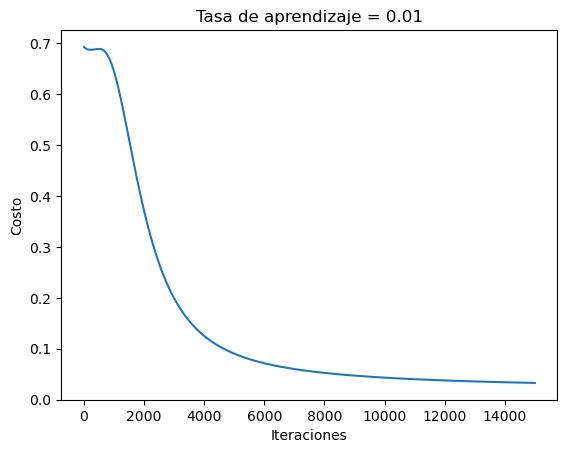

In [15]:
plt.plot(costs)
plt.ylabel('Costo')
plt.xlabel('Iteraciones')
plt.title("Tasa de aprendizaje = 0.01" )
plt.show()